Mean absolute error in train dataset: 25255.60
Mean absolute error in test dataset: 23864.68

R2 score in train dataset: 0.78
R2 score in test dataset: 0.73


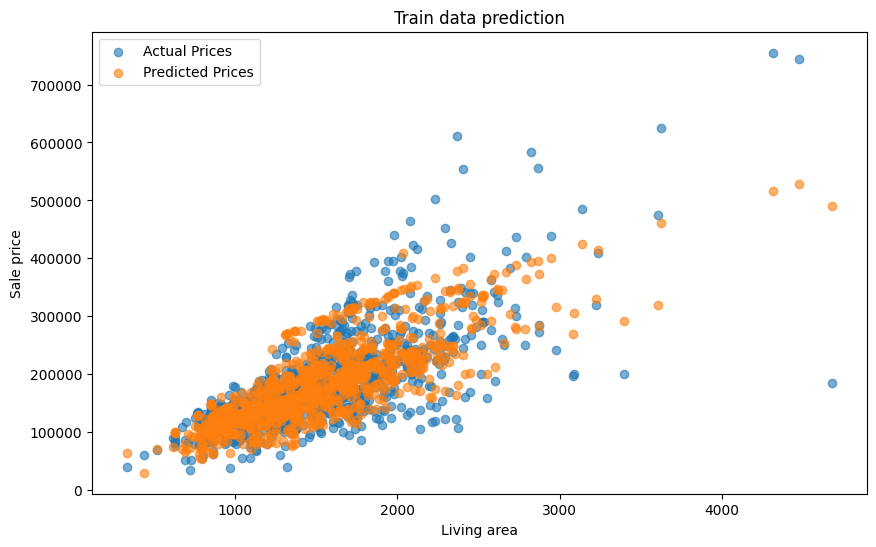

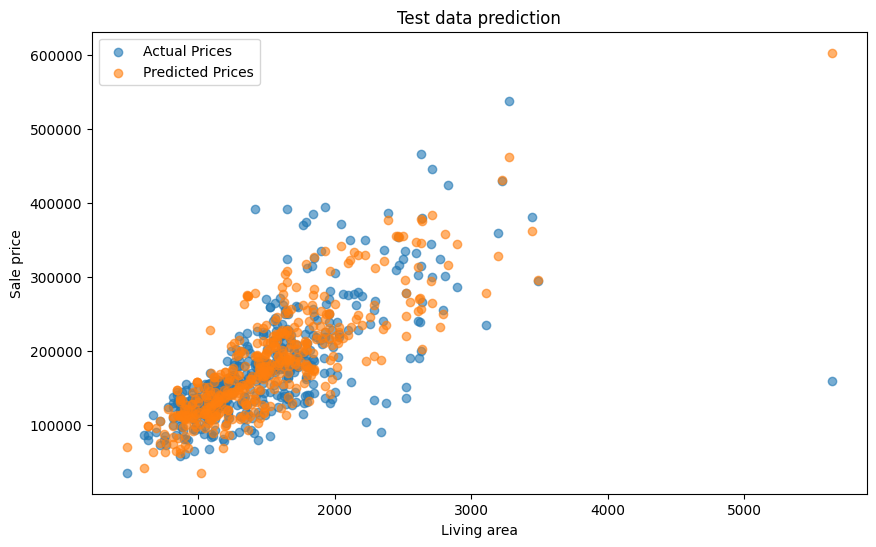

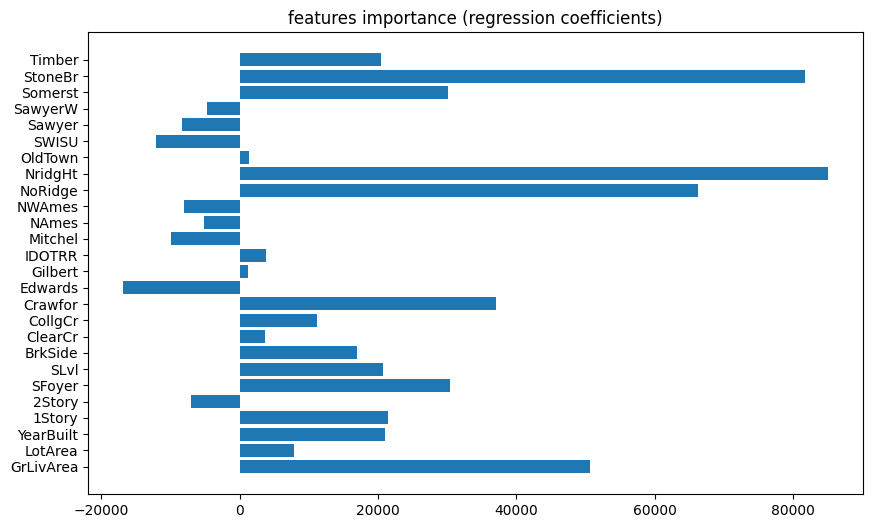

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

# Load CSV containing housing prices into Pandas DataFrame
df = pd.read_csv("HousePrice.csv")

# # Get basic information about data (features and response)
# print(df[["GrLivArea", "LotArea", "YearBuilt", "HouseStyle" , "Neighborhood", "SalePrice"]].info())        # display information about relevant columns
# print(df[["GrLivArea", "LotArea", "YearBuilt", "HouseStyle" , "Neighborhood", "SalePrice"]].head())        # display first 5 rows
# print(df[["GrLivArea", "LotArea", "YearBuilt", "HouseStyle" , "Neighborhood", "SalePrice"]].isna().sum())  # Check missing values, handle them (drop or impute) if exists

# No missing values found in the selected features and target columns; imputation is not required.

# Group numeric and categorical features separately for preprocessing
numeric_cols     = ["GrLivArea", "LotArea", "YearBuilt"]
categorical_cols = ["HouseStyle", "Neighborhood"]

# Convert categorical features (HouseStyle & Neighborhood) to dummy variables (drop_first=True used to avoid multicollinearity)
dummies_categorical_df = pd.get_dummies(df[categorical_cols], dtype=int, drop_first=True)

# # Find the frequencies for dummy variables
# house_style_dummies = dummies_categorical_df.filter(like="HouseStyle_")
# neighborhood_dummies = dummies_categorical_df.filter(like="Neighborhood_")
# print(house_style_dummies.sum().sort_values(ascending=False))
# print(neighborhood_dummies.sum().sort_values(ascending=False))

# Remove dummy variables for rare categories (less than 20 occurrences)
cols_to_drop = [col for col in dummies_categorical_df.columns
                if dummies_categorical_df[col].sum() < 20]
dummies_categorical_df.drop(columns=cols_to_drop, inplace=True)

# Scale numeric features using StandardScaler
scaler = StandardScaler()
scaled_numeric = scaler.fit_transform(df[numeric_cols]) # returns NumPy array

# Convert scaled numeric data to a DataFrame and preserve column names and index
scaled_numeric_df = pd.DataFrame(scaled_numeric, columns=numeric_cols, index=df.index)

# Prepare features (X) and target (y)
X = pd.concat([scaled_numeric_df, dummies_categorical_df], axis=1)
y = df["SalePrice"]

# Split data into train (70%) and test (30%) datasets randomly
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Fit linear regression model to training dataset
linreg_model = LinearRegression()
linreg_model.fit(X_train, y_train)

# Predict on train and test datasets
prediction_train = linreg_model.predict(X_train)
prediction_test = linreg_model.predict(X_test)

# Inverse transform the scaled numeric columns for plotting with original values
X_train_cont = scaler.inverse_transform(X_train.iloc[:, 0:3])
X_train_cont_df = pd.DataFrame(X_train_cont, columns=numeric_cols, index=X_train.index)
X_train = pd.concat([X_train_cont_df, X_train.iloc[:, 3:]], axis=1)
X_test_cont = scaler.inverse_transform(X_test.iloc[:, 0:3])
X_test_cont_df = pd.DataFrame(X_test_cont, columns=numeric_cols, index=X_test.index)
X_test = pd.concat([X_test_cont_df, X_test.iloc[:, 3:]], axis=1)

# Evaluate and display model accuracy with Mean Absolute Error for both train and test datasets
print(f"Mean absolute error in train dataset: {mean_absolute_error(y_train, prediction_train):.2f}")
print(f"Mean absolute error in test dataset: {mean_absolute_error(y_test, prediction_test):.2f}")

# Evaluate and display model accuracy with R2 Score for both train and test datasets
print(f"\nR2 score in train dataset: {r2_score(y_train, prediction_train):.2f}")
print(f"R2 score in test dataset: {r2_score(y_test, prediction_test):.2f}")

# Plot predictions vs actuals on train dataset
plt.figure(figsize=(10, 6))
plt.scatter(X_train["GrLivArea"], y_train, label="Actual Prices", alpha=0.6)
plt.scatter(X_train["GrLivArea"], prediction_train, label="Predicted Prices", alpha=0.6)
plt.title("Train data prediction")
plt.xlabel("Living area")
plt.ylabel("Sale price")
plt.legend(loc="upper left")
plt.show()

# Plot predictions vs actuals on test dataset
plt.figure(figsize=(10, 6))
plt.scatter(X_test["GrLivArea"], y_test, label="Actual Prices", alpha=0.6)
plt.scatter(X_test["GrLivArea"], prediction_test, label="Predicted Prices", alpha=0.6)
plt.title("Test data prediction")
plt.xlabel("Living area")
plt.ylabel("Sale price")
plt.legend(loc="upper left")
plt.show()

# Get regression coefficients of the trained model
features_importance = linreg_model.coef_

# Create a list of all feature names corresponding to regression coefficients
features = numeric_cols + list(
    dummies_categorical_df.columns
        .str.replace("HouseStyle_", "", regex=False)    # remove the HouseStyle_ prefix from dummy columns
        .str.replace("Neighborhood_", "", regex=False)  # remove the Neighborhood_ prefix from dummy columns
)

# Plot horizontal bar chart to show relative importance of the features using regression coefficients
plt.figure(figsize=(10, 6))
plt.barh(features, features_importance)
plt.title("features importance (regression coefficients)")
plt.show()